** This code requires a Bria API token: https://platform.bria.ai/register 

In [1]:
import os
from demo_utils import *
headers = {
  "Content-Type": "application/json",
  "api_token": os.getenv("BRIA_API_TOKEN") # Replace with your Bria API token
  }

# Welcome to Bria: AI-Powered Visual Content Generation

Bria is a visul-Gen-AI platform for builders, designed for commercial use and powered exclusively by licensed data.

This demo will showcase how developers can leverage Bria's APIs to build tools that enable their users to generate and modify brand-consistent visuals at scale.

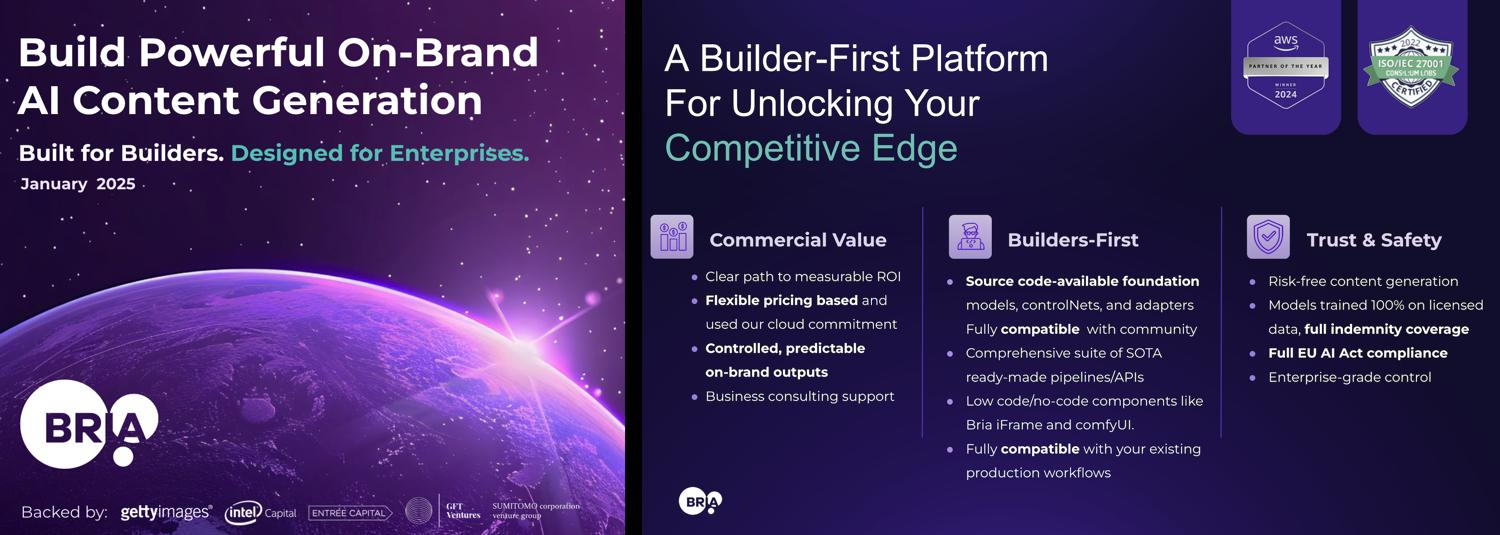

In [2]:
display_images([Image.open("./visuals/bria_intro.png")], resize = 1500)

## Leveraging Gen-AI for Brand Content Creation

We'll use **Bria's API** to show how a developer can easily **build** tools for creating and editing **controlled**, **on-brand** visuals **at scale**.

A strong brand identity includes visual features such as:

- **Color Palette**
- **Style & Mood**
- **Recurring Characters ("mascot") & Themes** 
- **Fonts** 
- **Logo**

The example below showcases how such features are present in the Bria brand:

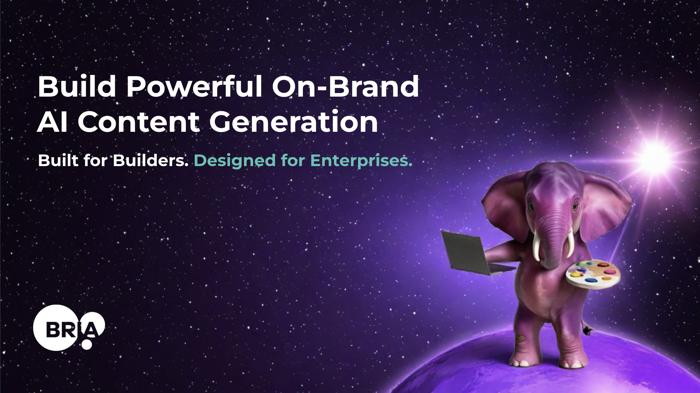

In [3]:
display_images([Image.open("./visuals/bria_brand_example.png")], resize=700)

## **Text-to-Image**: AI-Generated Visuals

Visual GenAI starts with text-to-image generation. 

Below, we define a function to generate images from a prompt using Bria's **text-to-image API**:

https://docs.bria.ai/image-generation/endpoints/text-to-image-fast

In [4]:
def text_to_image(prompt, num_results=3, model_version="2.3", fast=False, seed=42):
    """
    Generate AI-powered images from text prompts using Bria's API.
    
    Parameters:
    - prompt (str): The text description of the desired image.
    - model_version (str): foundation model version to use.
    - num_results (int): Number of images to generate.
    - fast (bool): Whether to use the fast generation endpoint.
    - seed (int): Seed for reproducibility.
    
    Returns:
    - List of generated image objects.
    """
    
    base_url = f"https://engine.prod.bria-api.com/v1/text-to-image/base/{model_version}"
    if fast:
        base_url = f"https://engine.prod.bria-api.com/v1/text-to-image/fast/{model_version}"

    payload = {
        "prompt": prompt, 
        "seed": seed, 
        "num_results": num_results,
        "sync": True, 
    }

    response = requests.post(base_url, json=payload, headers=headers)
    responses = response.json().get("result", [{}])
    print(responses[0].get("warning",""))
    image_urls = [x.get("urls", [None])[0] for x in responses]

    return return_images_from_urls(image_urls)

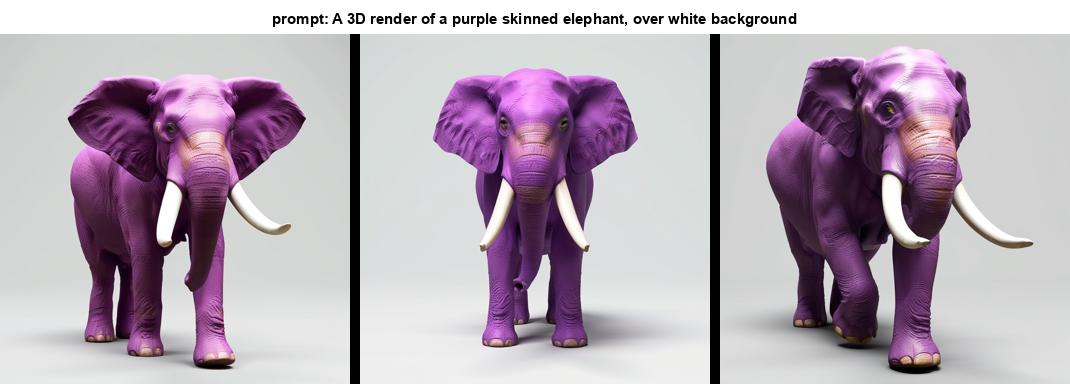

In [5]:
## Example: Generating an Image with Bria
# The following example demonstrates how Bria's API generates AI-driven visuals from text descriptions.

prompt = 'A 3D render of a purple skinned elephant, over white background'

images = text_to_image(prompt, num_results=3)
display_images(images, f"prompt: {prompt}")

### Reproducing The Brand Mascot

We want to enable users to accurately create visuals using their brand assets, such as the following examples of the **Bria Elephant**:

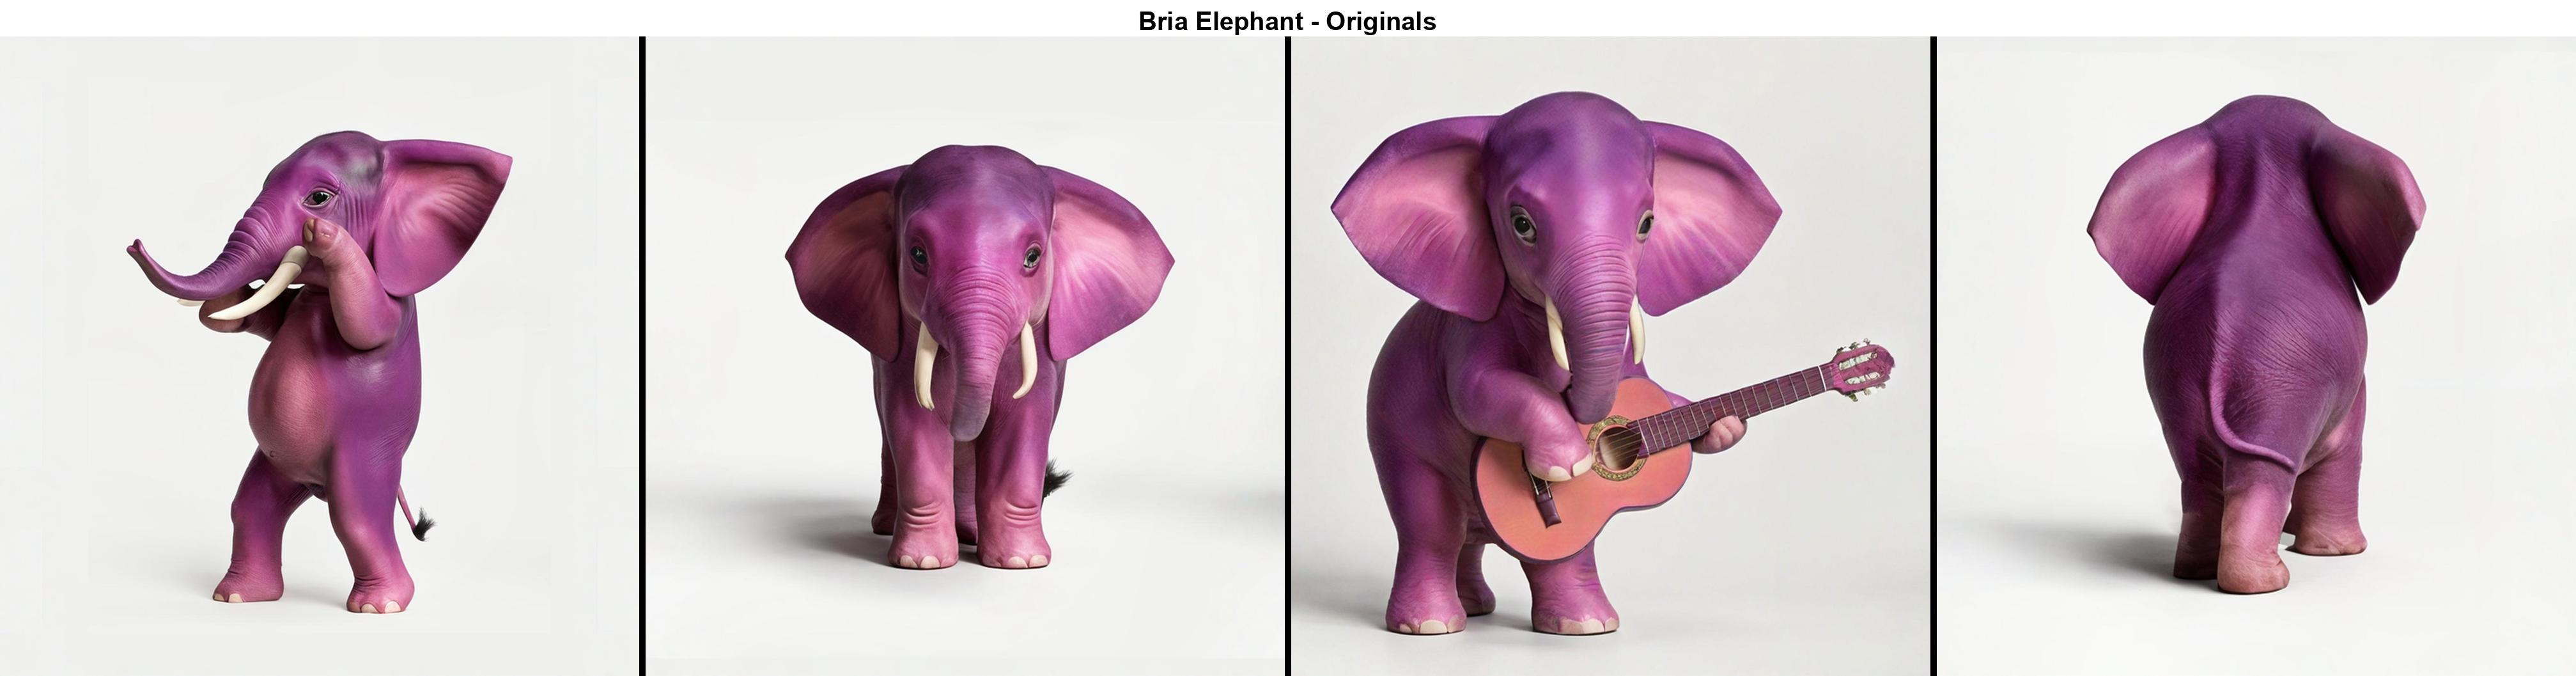

In [6]:
# load sample of bria elephant oiriginal images

bria_bear_dir = "briaphant"
images = [Image.open(f"{bria_bear_dir}/{f}") for f in os.listdir(bria_bear_dir) if "png" in f][:4]
display_images(images, "Bria Elephant - Originals", resize = 1000, font_size=40)

We need to add more components to the text-to-image generation to increase the controlability. We'll start by introducing **Control-Nets**.

## Image Guidance for Controlled Generation
We can add **structural control** using an input image to generate variations of that image, using the following Control Nets which were trained on-top of Bria's foundation text-to-image model:
- Canny
- Depth

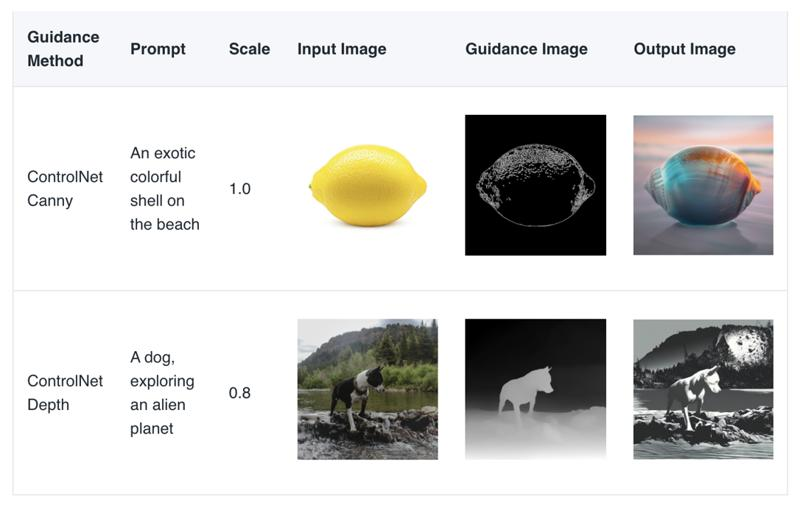

In [7]:
display_images([Image.open("./visuals/control_nets.png")], resize=800)

We'll choose one of the Bria Elephant original images and add structural image guidance to the generation using our trained ControlNets.

We can use Bria's **Reimagine API** which combines both ControlNets to reproduce the structure of the input image, while allowing changes through the textual prompt:

https://docs.bria.ai/image-generation/endpoints/reimagine-structure-reference

In [8]:
def text_to_image_with_guidance(prompt, guidance_image, num_results=3, fast=False, seed=42):
    
    base_url = "https://engine.prod.bria-api.com/v1/reimagine"

    payload = {
        "prompt": prompt, 
        "seed": seed, 
        "num_results": num_results,
        "sync": True, 
        "structure_image_file": pil_image_to_base64(guidance_image),
        "fast": fast
    }
    
    response = requests.post(base_url, json=payload, headers=headers)
    responses = response.json().get("result", [{}])
    image_urls = [x.get("urls", [None])[0] for x in responses]

    return return_images_from_urls(image_urls)

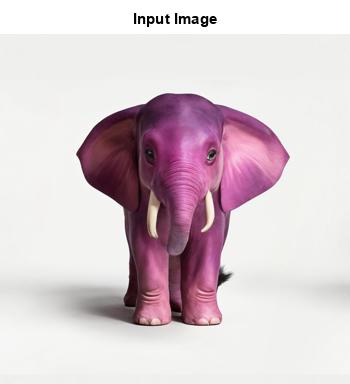

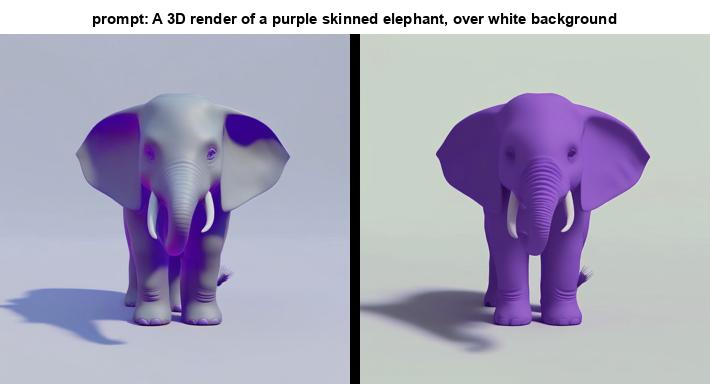

In [9]:
#Input:
prompt = 'A 3D render of a purple skinned elephant, over white background'
guidance_image = Image.open("./briaphant/bria_1afcb261_2000_49eb_a908_3656fd9a67fd_4.png")

images = text_to_image_with_guidance(prompt, guidance_image, num_results=2)
display_images([guidance_image], 'Input Image')
display_images(images, f"prompt: {prompt}")

We can use Reimagine to change the color of the Bria Elephant:

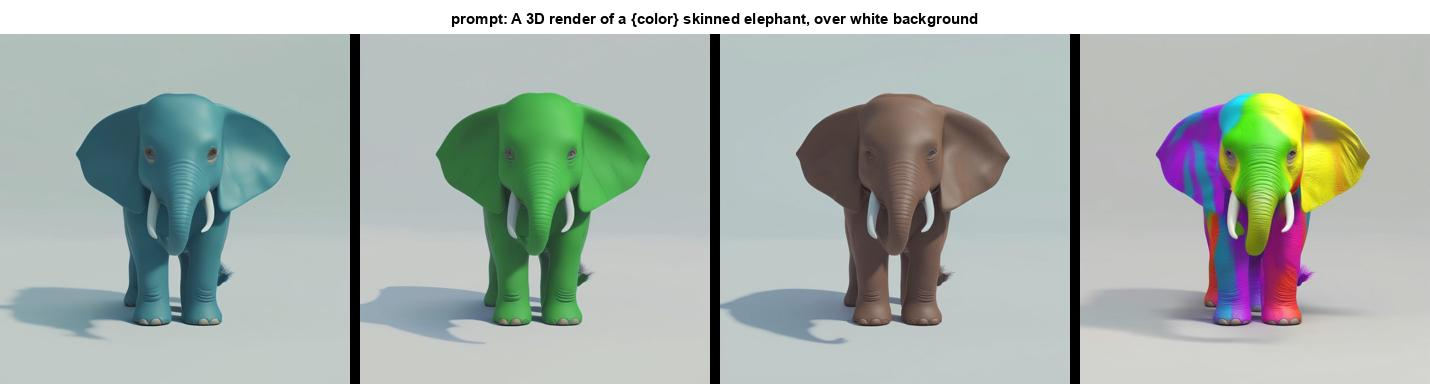

In [10]:
images = []
for color in ['blue', 'green', 'brown', 'rainbow colored']:
    prompt = f'A 3D render of a {color} skinned elephant, over white background'
    
    guidance_image = Image.open("./briaphant/bria_1afcb261_2000_49eb_a908_3656fd9a67fd_4.png")

    image = text_to_image_with_guidance(prompt, guidance_image, num_results=1)
    images.append(image[0])
display_images(images, 'prompt: A 3D render of a {color} skinned elephant, over white background')

In some cases this structural control is not enough. We want to enable our users to teach the model to generate a more accurate and varied represenation of this character.

We will allow this by enabling our users to **fine-tune** our foundation model using the original brand images they own.

## Tailored-Generation - Fine-Tuning with LoRA
### Training

We can fine-tune Bria's foundation model using the existing images of the Bria Elephant. For fine-tuning we would use Bria's **4B-Adapt** model, which is designed to provide exceptional fine-tuning capabilities for commercial use: https://huggingface.co/briaai/BRIA-4B-Adapt


We fine-tune using LoRA for easier deployment of each such fine-tuned model. 


Please refer to the following examples:

- Training using Bria's automatic Tailored-Gen API: gtc_demo_fine_tune_api.ipynb

- Training on-prem using Bria's foundation model weights on HF: gtc_demo_fine_tune_on_prem.ipynb

### Inference

We'll use Bria's Generate Image - Tailored Model API:

https://docs.bria.ai/tailored-generation/endpoints/text-to-image-tailored

In [ ]:
def tailored_gen(prompt, tailored_model, num_results=3, seed=42):
    
    base_url = f"https://engine.prod.bria-api.com/v1/text-to-image/tailored/{tailored_model}"

    payload = {
        "prompt": prompt, 
        "seed": seed, 
        "num_results": num_results,
        "sync": True, 
    }

    response = requests.post(base_url, json=payload, headers=headers)
    responses = response.json().get("result", [{}])
    image_urls = [x.get("urls", [None])[0] for x in responses]

    return return_images_from_urls(image_urls)

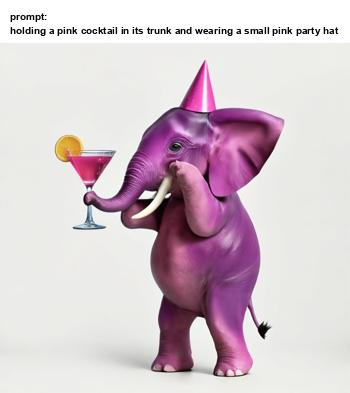

In [12]:
prompt = "holding a pink cocktail in its trunk and wearing a small pink party hat"
tailored_model = 10920
elephant_image = tailored_gen(prompt, tailored_model, num_results=1)[0]
elephant_image.save('./api_results/elephant_image.jpg')
display_images([elephant_image], f"prompt: \n{prompt}", font_size=10)

## Background Genreation (from Textual Prompt)


Great. Now let's place this festive character in a proper location by generating on-brand backgrounds around it.
We'll use Bria's Generate Background API:

https://docs.bria.ai/image-editing/endpoints/background-replace



We used an LLM to write a few prompts for background images that could be relevant for this character in a festive event. 

In [13]:
def generate_bg_by_text(foreground_image, prompt, num_results=1, seed=42, padding=[0, 0, 0, 0]):
    
    base_url = "https://engine.prod.bria-api.com/v1/background/replace"

    payload = {
        "file": pil_image_to_base64(foreground_image),
        "bg_prompt": prompt,
        "sync": True,
        "placement_type": "manual_padding",
        "num_results": num_results,
        "seed": seed,         
        "padding_values": padding
    }

    response = requests.post(base_url, json=payload, headers=headers)
    responses = response.json().get("result", [{}])
    image_urls = [x[0] for x in responses]

    return return_images_from_urls(image_urls)

In [14]:
background_prompts = [
 'A tropical beach at sunset with palm trees, soft waves, and string lights, perfect for a relaxing party vibe',
 'A winter wonderland party with twinkling snowflakes, icy-blue lighting, and festive holiday purple decorations creating a cozy atmosphere',
 'A cosmic galaxy party with glowing planets, swirling nebulas, and a dance floor that looks like the surface of the moon.',
 ]
bg_originals_dir = "./api_results/bg_gen/bg_by_text"

# generate style backgrounds
os.makedirs(bg_originals_dir, exist_ok=True)

foreground_image = Image.open('./api_results/elephant_image.jpg')
resize_scale = 0.25 # we'll make the elephant 25% smaller to fit into the background images
# we want the elephant to be positioned in the bottom right corner of the background image, so we'll add padding accordingly
width_padding = int(foreground_image.size[0]*resize_scale)
height_padding = int(foreground_image.size[1]*resize_scale)
bottom_right_location = [width_padding, 0, height_padding, 0]

all_bg_images = []
for i, prompt in enumerate(background_prompts):
    bg_images = generate_bg_by_text(foreground_image, prompt, num_results=1, padding=bottom_right_location)
    bg_images[0].save(f'{bg_originals_dir}/{i}.png')
    all_bg_images.append(bg_images[0])

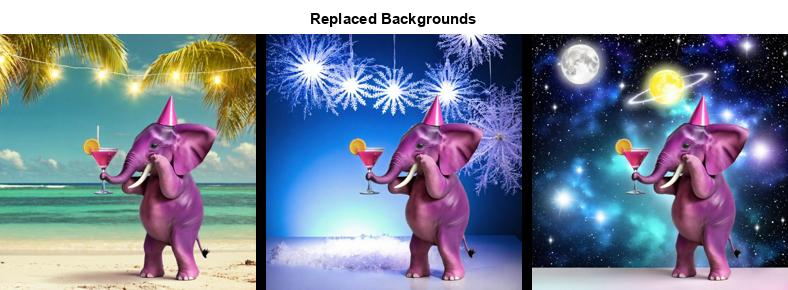

In [15]:
# display results
all_bg_images = [Image.open(f'{bg_originals_dir}/{i}.png') for i in range(len(background_prompts))]
display_images(all_bg_images,  f"Replaced Backgrounds", resize = 256)

The generated backgrounds are not exactly in the style of the brand. We can train another tailored-model some images that are on-brand:

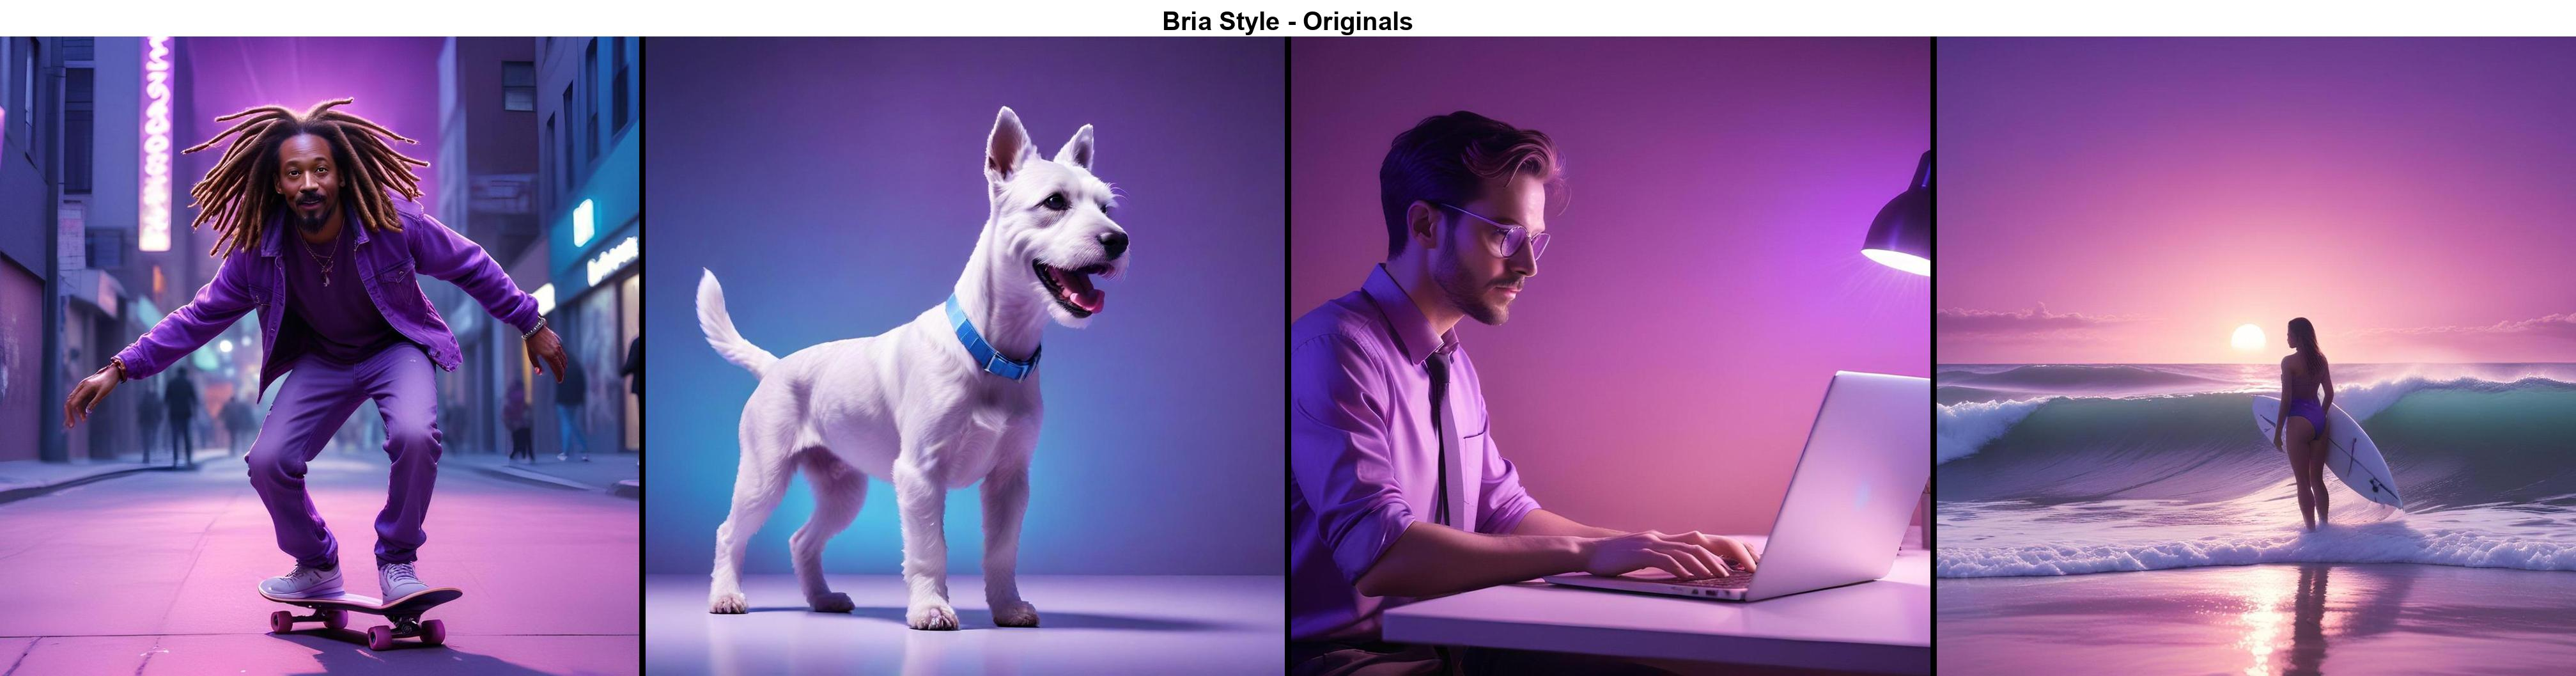

In [16]:
# load sample of bria style oiriginal images
bria_style_dir = "bria_style"

images = [Image.open(f"{bria_style_dir}/{f}") for f in os.listdir(bria_style_dir)][:4]
display_images(images, "Bria Style - Originals", resize = 1000, font_size=40)

We'll first genearte just the backgrounds, this time in the brand style, and later add the brand mascot:

In [17]:
bg_originals_dir = "./api_results/bg_gen/bg_originals"

# generate style backgrounds
os.makedirs(bg_originals_dir, exist_ok=True)

all_bg_images = []
for i, prompt in enumerate(background_prompts):
    tailored_model = 10900
    bg_image = tailored_gen(prompt, tailored_model, num_results=1)[0]
    bg_image.save(f'{bg_originals_dir}/{i}.png')
    all_bg_images.append(bg_image)

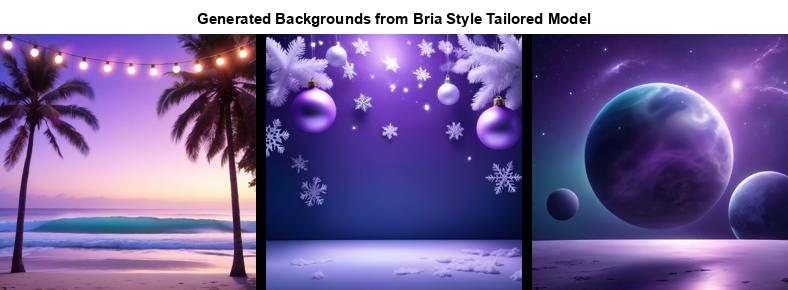

In [18]:
# display results
all_bg_images = [Image.open(f'{bg_originals_dir}/{i}.png') for i in range(len(background_prompts))]
display_images(all_bg_images, f"Generated Backgrounds from Bria Style Tailored Model", resize = 256)


## Background Genreation (by Reference Image)
Next, we want to use those brand style backgrounds as inspiration for new background for our festive Bria Elephant. 

We'll use Bria's Generate Background API:


https://docs.bria.ai/image-editing/endpoints/background-replace

In [19]:
def generate_bg_by_image(foreground_image, bg_image, num_results=1, seed=42, padding=[0, 0, 0, 0]):
    
    base_url = "https://engine.prod.bria-api.com/v1/background/replace"

    payload = {
        "file": pil_image_to_base64(foreground_image),
        "ref_image_file": pil_image_to_base64(bg_image),
        "sync": True,
        "placement_type": "manual_padding",
        "num_results": num_results,
        "seed": seed,         
        "padding_values": padding
    }

    response = requests.post(base_url, json=payload, headers=headers)
    responses = response.json().get("result", [{}])
    image_urls = [x[0] for x in responses]

    return return_images_from_urls(image_urls)

In [20]:
bg_generations_dir = "./api_results/bg_gen/bg_generations"

# generate backgrounds for elephant
os.makedirs(bg_generations_dir, exist_ok=True)

all_bg_images = [Image.open(f'{bg_originals_dir}/{i}.png') for i in range(len(background_prompts))]

foreground_image = Image.open('./api_results/elephant_image.jpg')
resize_scale = 0.25 # we'll make the elephant 25% smaller to fit into the background images

# we want the elephant to be positioned in the bottom right corner of the background image, so we'll add padding accordingly
width_padding = int(foreground_image.size[0]*resize_scale)
height_padding = int(foreground_image.size[1]*resize_scale)
bottom_right_location = [width_padding, 0, height_padding, 0]

all_images = []
for i, bg_img in enumerate(all_bg_images):

    new_bg_img = generate_bg_by_image(foreground_image, bg_img, num_results=1, padding=bottom_right_location)
    new_bg_img[0].save(f'{bg_generations_dir}/{i}.png')
    all_images.append(new_bg_img[0])


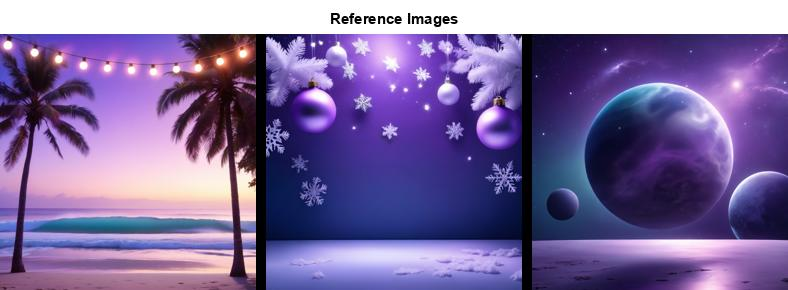

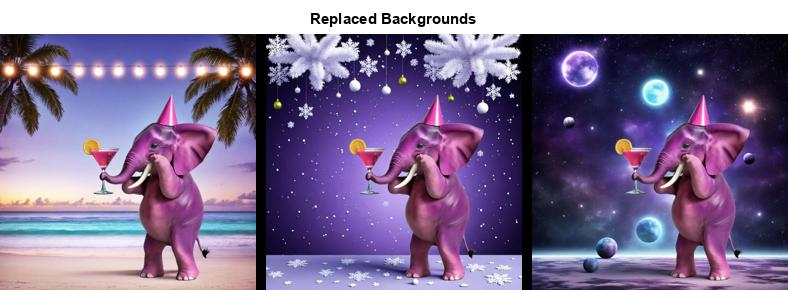

In [21]:
# display results
all_bg_images = [Image.open(f'{bg_originals_dir}/{i}.png') for i in range(len(background_prompts))]
all_images = [Image.open(f'{bg_generations_dir}/{i}.png') for i in range(len(background_prompts))]
display_images(all_bg_images[:3], f"Reference Images", resize = 256)
display_images(all_images[:3],  f"Replaced Backgrounds", resize = 256)


## Image Editing: Generative Fill

Focusing on the first 3 outputs, let's fix some content issues by replacing or adding content using Bria's Generative-Fill API:

https://docs.bria.ai/image-editing/endpoints/gen-fill

In [22]:
def gen_fill(original_image, mask, prompt, num_results=1, seed=42):
    
    base_url = "https://engine.prod.bria-api.com/v1/gen_fill"

    payload = {
        "file": pil_image_to_base64(original_image),
        "mask_file": pil_image_to_base64(mask.convert('RGB')),
        "mask_type": "manual",
        "prompt": prompt,
        "num_results": num_results,
        "sync": True,
        "seed": seed,
    }

    response = requests.post(base_url, json=payload, headers=headers)
    responses = response.json().get("urls", [])
    image_urls = [x for x in responses]

    return return_images_from_urls(image_urls)


The first image is a beach scene, let's replace the party hat with some beachwear. We'll use a mask around the hat we want to replace, and specifiy the new content in "prompt":

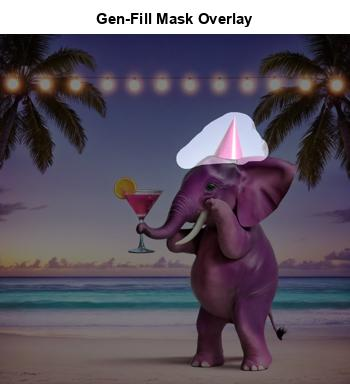

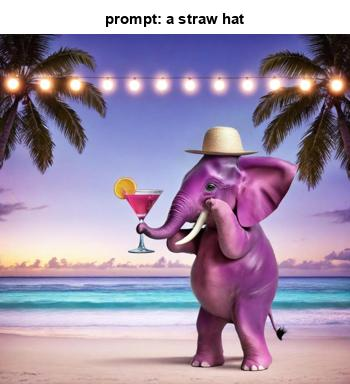

In [23]:
input_image = Image.open('./api_results/bg_gen/bg_generations/0.png')
mask = Image.open('./api_results/masks/hat_mask.png')
prompt = "a straw hat"

display_mask(mask, input_image)

output_var1 = gen_fill(input_image, mask, prompt)[0]
output_var1.save(f'./api_results/bg_gen/bg_generations/0_fixed.png')
display_images([output_var1], f"prompt: {prompt}")

Now let's replace the hat in the second image to something more suitable for winter festivities:

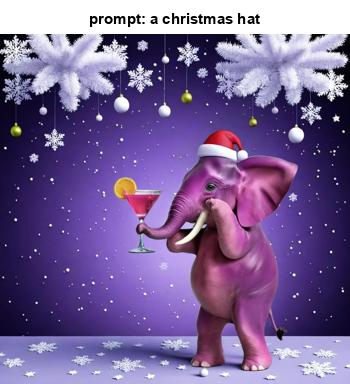

In [24]:
input_image = Image.open(f'./api_results/bg_gen/bg_generations/1.png')
mask = Image.open('./api_results/masks/hat_mask.png')
prompt = "a christmas hat"

output_var2 = gen_fill(input_image, mask, prompt)[0]
output_var2.save(f'./api_results/bg_gen/bg_generations/1_fixed.png')
display_images([output_var2], f"prompt: {prompt}")

We can also add a christmas tree in the brand colors

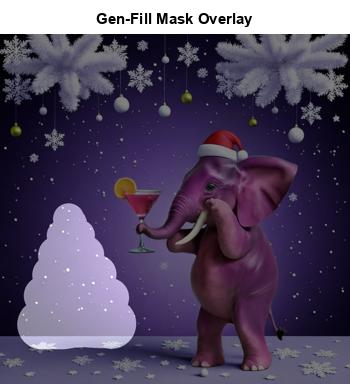

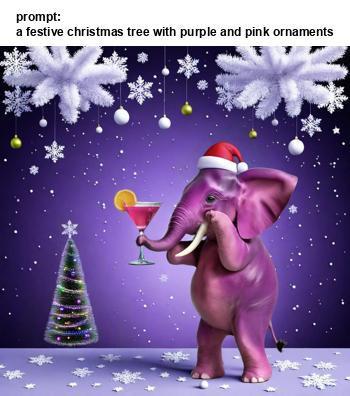

In [25]:
input_image = Image.open(f'./api_results/bg_gen/bg_generations/1_fixed.png')
mask = Image.open('./api_results/masks/tree_mask.png')
prompt = "a festive christmas tree with purple and pink ornaments"

display_mask(mask, input_image)

output_var2 = gen_fill(input_image, mask, prompt)[0]
output_var2.save(f'./api_results/bg_gen/bg_generations/1_fixed.png')
display_images([output_var2], f"prompt: \n{prompt}", font_size=12)

## Image Editing: Eraser
And finally, the summer cocktail doesn't align with the winter theme, so let's remove it. 

We'll use Bria's Eraser API:

https://docs.bria.ai/image-editing/endpoints/eraser

In [26]:
def erase(original_image, mask):
    
    base_url = "https://engine.prod.bria-api.com/v1/eraser"

    payload = {
        "file": pil_image_to_base64(original_image),
        "mask_file": pil_image_to_base64(mask.convert('RGB')),
        "mask_type": "manual",
        "sync": True,
    }

    response = requests.post(base_url, json=payload, headers=headers)
    responses = response.json().get("result_url", '')
    image_urls = [responses]

    return return_images_from_urls(image_urls)


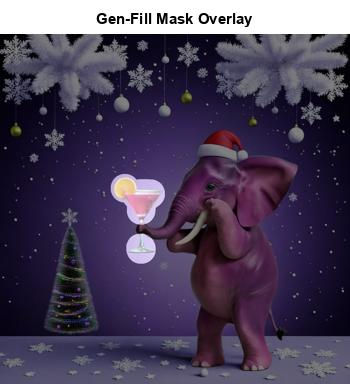

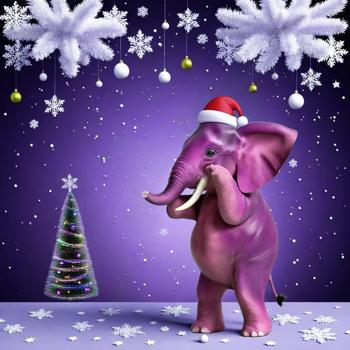

In [27]:
input_image = Image.open(f'./api_results/bg_gen/bg_generations/1_fixed.png')
mask = Image.open('./api_results/masks/cocktail_mask.png')

display_mask(mask, input_image)

output_var2 = erase(input_image, mask)[0]
output_var2.save(f'./api_results/bg_gen/bg_generations/1_fixed.png')
display_images([output_var2])

## Image Editing: Expand

We now have our 3 image varaiations ready. But what if we wanted to use them in adds with different aspect ratios? 

We'll use Bria's Expand Image API to expand the image to different aspect ratios:

https://docs.bria.ai/image-editing/endpoints/image-expansion

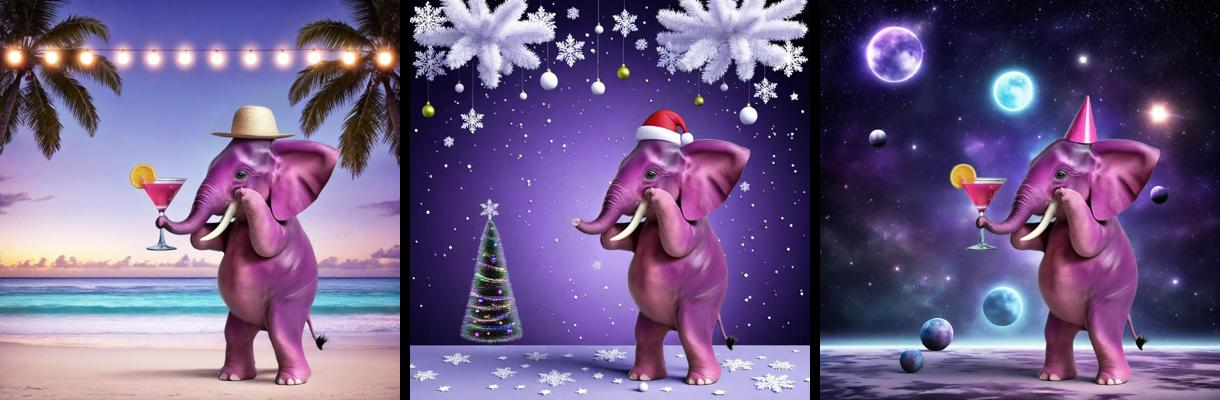

In [28]:
output_var1 = Image.open(f'./api_results/bg_gen/bg_generations/0_fixed.png')
output_var2 = Image.open(f'./api_results/bg_gen/bg_generations/1_fixed.png')
output_var3 = Image.open(f'./api_results/bg_gen/bg_generations/2.png')
image_variations = [output_var1, output_var2, output_var3]
display_images(image_variations, resize = 400)

In [29]:
def expand_left(input_image, seed=42):
    org_width, org_height = input_image.size
    
    base_url = "https://engine.prod.bria-api.com/v1/image_expansion"

    payload = {
        "file": pil_image_to_base64(input_image),
        "canvas_size": [
            org_width*2,
            org_height
        ],
        "original_image_size": [
            org_width,
            org_height
        ],
        "original_image_location": [
            org_width-20,
            0
        ],
        "seed": seed
    }

    response = requests.post(base_url, json=payload, headers=headers)
    responses = response.json().get("result_url", '')
    image_urls = [responses]

    return return_images_from_urls(image_urls)

def expand_top(input_image, seed=42):
    org_width, org_height = input_image.size
    
    base_url = "https://engine.prod.bria-api.com/v1/image_expansion"

    payload = {
        "file": pil_image_to_base64(input_image),
        "canvas_size": [
            org_width,
            org_height*2
        ],
        "original_image_size": [
            org_width,
            org_height-20
        ],
        "original_image_location": [
            0,
            org_height
        ],
        "seed": seed
    }

    response = requests.post(base_url, json=payload, headers=headers)
    responses = response.json().get("result_url", '')
    image_urls = [responses]

    return return_images_from_urls(image_urls)


In [30]:
output_var1 = Image.open(f'./api_results/bg_gen/bg_generations/0_fixed.png')
output_var2 = Image.open(f'./api_results/bg_gen/bg_generations/1_fixed.png')
output_var3 = Image.open(f'./api_results/bg_gen/bg_generations/2.png')
image_variations = [output_var1, output_var2, output_var3]

In [31]:
expanded_images_left = []
for i, image_var in enumerate(image_variations):
    exp_img = expand_left(image_var)[0]
    expanded_images_left.append(exp_img)
    exp_img.save(f'./api_results/bg_gen/bg_generations/{i}_exp_left.png')

In [32]:
expanded_images_top = []
for i, image_var in enumerate(image_variations):
    exp_img = expand_top(image_var)[0]
    expanded_images_top.append(exp_img)
    exp_img.save(f'./api_results/bg_gen/bg_generations/{i}_exp_top.png')

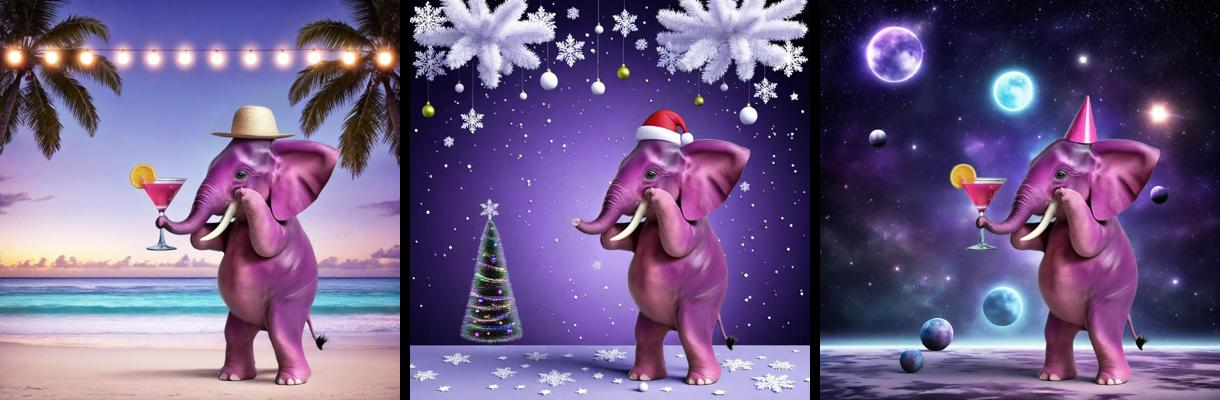

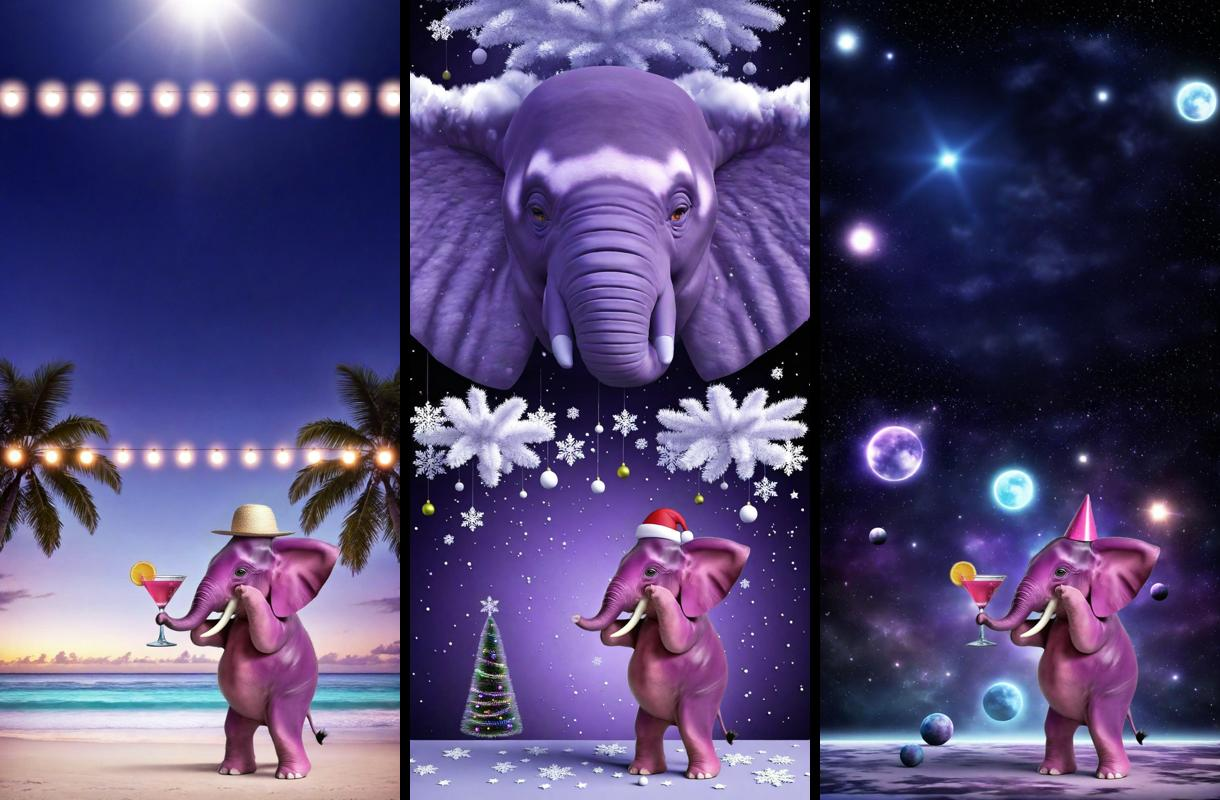

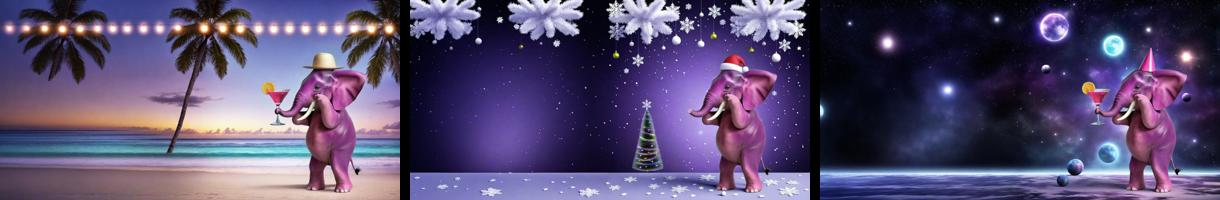

In [33]:
expanded_images_left = [Image.open(f'./api_results/bg_gen/bg_generations/{i}_exp_left.png') for i in range(3)]
expanded_images_top = [Image.open(f'./api_results/bg_gen/bg_generations/{i}_exp_top.png') for i in range(3)]

display_images(image_variations, resize = 400)
display_images(expanded_images_top, resize = 800)
display_images(expanded_images_left, resize = 400)

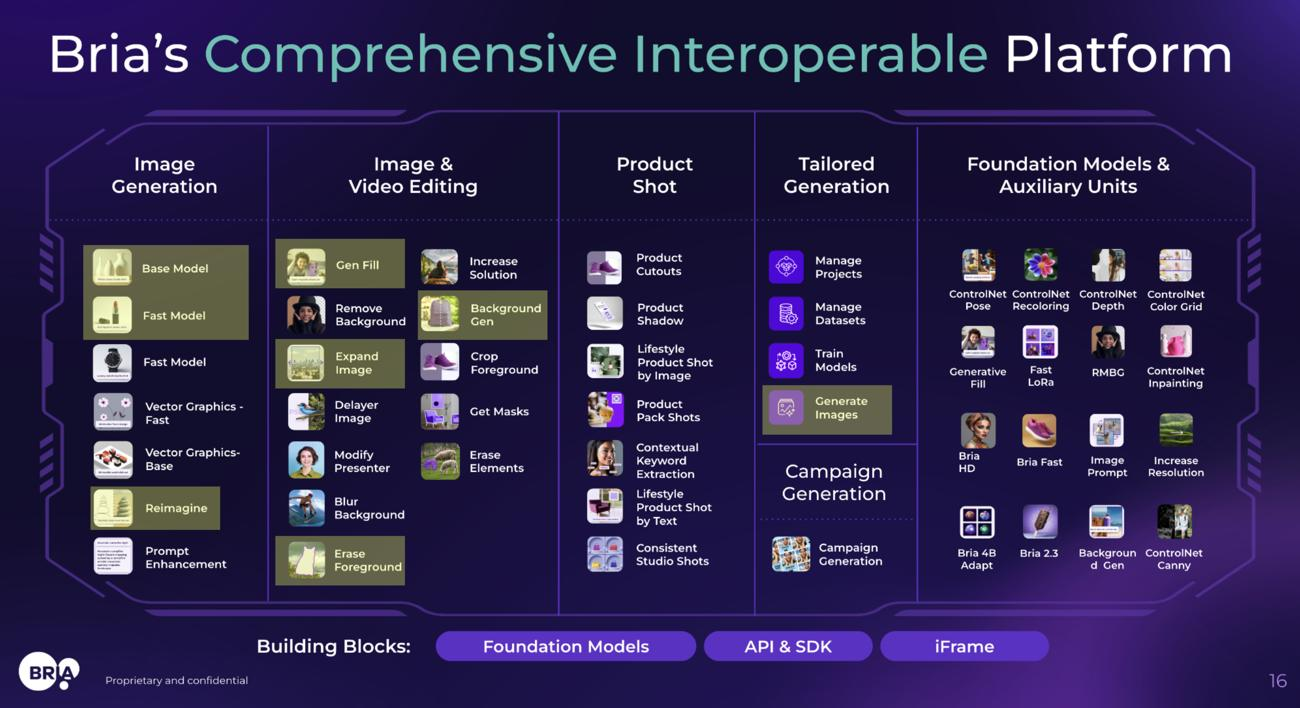

In [34]:
display_images([Image.open("./visuals/bria_intro2.png")], resize = 1300)